# Import libraries and data


In [1]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python


In [2]:
#import libraries
import xgboost as xgb
import itertools
from fbprophet import Prophet
import pandas as pd
import numpy as np

In [3]:
#get the data
data = pd.read_csv("Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [4]:
#select variables
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)                       

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#Data Transformation

In [5]:
#Date variable
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [6]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#holidays

In [7]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [8]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


#Training and Test Set

In [9]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846


#Facebook Prophet

In [10]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 20,
            holidays_prior_scale = 20,
            changepoint_prior_scale = 0.01)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

#forecasting 

In [11]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [12]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [13]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holi,holi_lower,holi_upper,holidays,holidays_lower,holidays_upper,hum,hum_lower,hum_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,temp,temp_lower,temp_upper,weathersit,weathersit_lower,weathersit_upper,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2428.959073,222.633419,2219.733906,2428.959073,2428.959073,-0.055485,-0.055485,-0.055485,-0.279300,-0.279300,-0.279300,0.0,0.0,0.0,0.0,0.0,0.0,-0.070485,-0.070485,-0.070485,-0.483167,-0.483167,-0.483167,-0.089004,-0.089004,-0.089004,-0.084177,-0.084177,-0.084177,0.058168,0.058168,0.058168,0.019851,0.019851,0.019851,0.000000,0.000000,0.000000,-0.262035,-0.262035,-0.262035,0.0,0.0,0.0,1255.366957
1,2011-01-02,2434.578651,46.373431,1975.128624,2434.578651,2434.578651,-0.060155,-0.060155,-0.060155,-0.288027,-0.288027,-0.288027,0.0,0.0,0.0,0.0,0.0,0.0,-0.027599,-0.027599,-0.027599,-0.585264,-0.585264,-0.585264,-0.078185,-0.078185,-0.078185,-0.084177,-0.084177,-0.084177,-0.041308,-0.041308,-0.041308,-0.037911,-0.037911,-0.037911,0.000000,0.000000,0.000000,-0.255930,-0.255930,-0.255930,0.0,0.0,0.0,1009.706277
2,2011-01-03,2440.198229,384.066357,2268.729344,2440.198229,2440.198229,-0.137785,-0.137785,-0.137785,-0.188057,-0.188057,-0.188057,0.0,0.0,0.0,0.0,0.0,0.0,0.073537,0.073537,0.073537,-0.462290,-0.462290,-0.462290,-0.171815,-0.171815,-0.171815,0.052537,0.052537,0.052537,-0.025655,-0.025655,-0.025655,-0.037760,-0.037760,-0.037760,0.033228,0.033228,0.033228,-0.248577,-0.248577,-0.248577,0.0,0.0,0.0,1312.120106
3,2011-01-04,2445.817807,510.264658,2417.792074,2445.817807,2445.817807,-0.127053,-0.127053,-0.127053,-0.177430,-0.177430,-0.177430,0.0,0.0,0.0,0.0,0.0,0.0,0.013686,0.013686,0.013686,-0.418997,-0.418997,-0.418997,-0.169778,-0.169778,-0.169778,0.052537,0.052537,0.052537,-0.001477,-0.001477,-0.001477,0.019950,0.019950,0.019950,0.033228,0.033228,0.033228,-0.240090,-0.240090,-0.240090,0.0,0.0,0.0,1421.028542
4,2011-01-05,2451.437386,642.496537,2542.458811,2451.437386,2451.437386,-0.118953,-0.118953,-0.118953,-0.111696,-0.111696,-0.111696,0.0,0.0,0.0,0.0,0.0,0.0,0.073660,0.073660,0.073660,-0.347872,-0.347872,-0.347872,-0.154674,-0.154674,-0.154674,0.052537,0.052537,0.052537,-0.005576,-0.005576,-0.005576,0.002506,0.002506,0.002506,0.033228,0.033228,0.033228,-0.230600,-0.230600,-0.230600,0.0,0.0,0.0,1598.652066


#XGBoost preparation

In [14]:
prophet_variables = forecast.loc[:, ["trend", "holi", "weekly", "yearly"]]
df_xgb = pd.concat([dataset, prophet_variables], axis = 1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2428.959073,0.0,0.058168,-0.262035
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2434.578651,0.0,-0.041308,-0.255930
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2440.198229,0.0,-0.025655,-0.248577
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2445.817807,0.0,-0.001477,-0.240090
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2451.437386,0.0,-0.005576,-0.230600


In [15]:
#Training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846,6422.673967,0.0,-0.025655,-0.264591


In [16]:
#isolate X and Y
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [19]:
#create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

#XGBoost

In [21]:
#Set the parameters
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

In [22]:
#XGBoost Model
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")],
                  verbose_eval = 15)

[0]	y-rmse:3891.59
[15]	y-rmse:1607.49
[30]	y-rmse:1368.37
[45]	y-rmse:1290.71
[60]	y-rmse:1252.2
[75]	y-rmse:1212.15
[90]	y-rmse:1199.75
[99]	y-rmse:1179.15


#Forecasting and Visualization

In [26]:
#Forecasting
predictions_xgb = pd.Series(model.predict(Test), name = "XGBoost")
predictions_xgb.index = test_set.ds
predictions_xgb[:2]

ds
2012-12-01    4020.162598
2012-12-02    3019.301025
Name: XGBoost, dtype: float32

In [27]:
#set up index
training_set.index = training_set.ds
test_set.index = test_set.ds

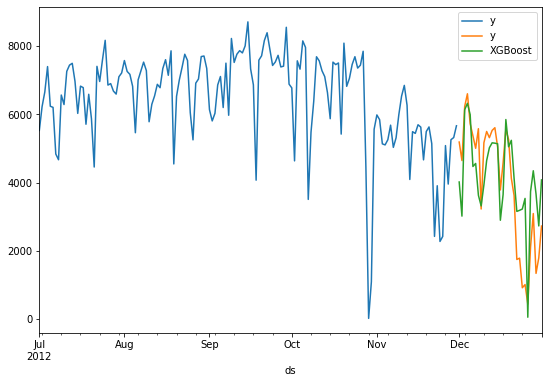

In [31]:
#Viz
training_set.y['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

#Model assessment

In [32]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))

954.0
1179.0


In [33]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_xgb)

45.99199599293936

#export forecasts

In [34]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble


In [35]:
predictions_xgb.to_csv('predictions_xgb.csv', index = True)